# Combined Exercise Notebook for 08_Graph_Convnets

This notebook contains all exercise notebooks from the 08_Graph_Convnets folder:

- code01_exercise.ipynb
- code02_exercise.ipynb
- code03_exercise.ipynb
- code04_exercise.ipynb
- code05_exercise.ipynb

**Generated on:** combine_notebooks.py


# --------------------------------------------------------------------------------
# Code01 Exercise
# --------------------------------------------------------------------------------


# Lecture : Graph Convolutional Networks

## Lab 01 : ChebNets -- Exercise

### Xavier Bresson, Nian Liu

Defferrard, Bresson, Vandergheynst, Convolutional Neural Networks on Graphs with Fast Localized Spectral Filtering, 2016  
https://arxiv.org/pdf/1606.09375


In [ ]:
# For Google Colaboratory
import sys, os
if 'google.colab' in sys.modules:
    # mount google drive
    from google.colab import drive
    drive.mount('/content/gdrive')
    path_to_file = '/content/gdrive/My Drive/CS5284_2024_codes/codes/08_Graph_Convnets'
    print(path_to_file)
    # change current path to the folder containing "path_to_file"
    os.chdir(path_to_file)
    !pwd
    

In [1]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import collections
import time
import numpy as np
import sys
sys.path.insert(0, 'lib/')
%load_ext autoreload
%autoreload 2


## MNIST


In [2]:
# Load small MNIST
[train_data, train_label, test_data, test_label] = torch.load('datasets/MNIST_1k.pt')
print('train_data',train_data.size())
print('train_label',train_label.size())
print('test_data',test_data.size())
print('test_label',test_label.size())


train_data torch.Size([1000, 784])
train_label torch.Size([1000])
test_data torch.Size([100, 784])
test_label torch.Size([100])


## Compute coarsened graphs


In [3]:
from lib.grid_graph import grid_graph
from lib.coarsening import coarsen
from lib.coarsening import lmax_L
from lib.coarsening import perm_data
from lib.coarsening import rescale_L

# Construct grid graph
t_start = time.time()
grid_side = 28  # Each image is 28 * 28
number_edges = 8  # Each pixel has eight neighbors
A = grid_graph(grid_side, number_edges, 'euclidean') # create graph of Euclidean grid

# Compute coarsened graphs
num_coarsening_levels = 4
L, perm = coarsen(A, num_coarsening_levels)

# Compute largest eigenvalue of graph Laplacians
lmax = []
for i in range(num_coarsening_levels):
    lmax.append(lmax_L(L[i]))
print('lmax: ' + str([lmax[i] for i in range(num_coarsening_levels)]))

# Reindex nodes to satisfy a binary tree structure
train_data = perm_data(train_data, perm)
test_data = perm_data(test_data, perm)
train_data = torch.tensor(train_data).float()
test_data = torch.tensor(test_data).float()
print(train_data.size())
print(test_data.size())

print('Execution time: {:.2f}s'.format(time.time() - t_start))
del perm


nb edges:  6396
Heavy Edge Matching coarsening with Xavier version
Layer 0: M_0 = |V| = 928 nodes (144 added), |E| = 3198 edges
Layer 1: M_1 = |V| = 464 nodes (61 added), |E| = 1618 edges
Layer 2: M_2 = |V| = 232 nodes (20 added), |E| = 791 edges
Layer 3: M_3 = |V| = 116 nodes (5 added), |E| = 388 edges
Layer 4: M_4 = |V| = 58 nodes (0 added), |E| = 190 edges
lmax: [1.3857564, 1.344093, 1.227859, 1.0]
torch.Size([1000, 928])
torch.Size([100, 928])
Execution time: 0.16s


c:\Users\64483\Desktop\CS5284 Graph ML\CS5284_2025\codes\08_Graph_Convnets\lib\coarsening.py:239: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if len(indices_node) is 1:
c:\Users\64483\Desktop\CS5284 Graph ML\CS5284_2025\codes\08_Graph_Convnets\lib\coarsening.py:244: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif len(indices_node) is 0:


## Question 1: Implement ChebNet based on the CNN LeNet-5 architecture

- First layer : CL with 32 features
- Second layer : MaxPooling to reduce graph size by a factor 4
- Third layer : CL with 64 features
- Fourth layer : MaxPooling to reduce graph size by a factor 4
- Fifth layer : Fully connected (or linear) layer with 512 features 
- Last layer : Fully connected (or linear) layer with 10 output values for 10 classes 


Instructions:

Step 1: Define the model architecture with the constructor `def __init__()`.
  - Use [torch.nn.Linear()](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear) to linearly transform the feature dimensions. 
  - Convert the SciPy sparse graph Laplacian and its coarsened versions to PyTorch sparse matrices with [torch.sparse.FloatTensor(indices, data, shape)](https://pytorch.org/docs/stable/sparse.html).
  - For a [scipy.sparse.coo_matrix](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.coo_matrix.html) L, `L.row`, `L.col` and `L.data` are the row indices, column indices, and weights for each edge, respectively.

Step 2: Define MaxPooling layers in `def graph_max_pool()` using [torch.nn.MaxPool1d()](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool1d.html#torch.nn.MaxPool1d).
  - Note that the pooling is done along the node dimension (analogous to a 1D sequence) and not the feature dimension.
  - Use [torch.permute()](https://pytorch.org/docs/stable/generated/torch.permute.html#torch.permute) to reorder the tensor dimensions to apply `torch.nn.MaxPool1d()`, and [.contiguous()](https://pytorch.org/docs/stable/generated/torch.Tensor.contiguous.html#torch.Tensor.contiguous) to ensure a contiguous memory layout for the target tensor.

Step 3: Implement ChebNet convolution in `def graph_conv_cheby()`.
  - Compute explicitly the first two Chebyshev terms, then code the recursive formula.
  - Use [torch.sparse.mm()](https://pytorch.org/docs/stable/generated/torch.sparse.mm.html#torch.sparse.mm) to perform matrix multiplication between two sparse matrices, which is less memory consuming than [torch.mm()](https://pytorch.org/docs/stable/generated/torch.mm.html#torch.mm).
  - Node features are integrated into the first two terms, so the following terms automatically contain node features via recursive iterations, see Slides 34 and 35 from the lecture.
  - Combine the results from all intermediate Chebyshev orders to get the output, by linearly transforming them to match the input dimension of the next layer.

Step 4: Implement the forward pass in `def forward()`.
  - For CL1 and CL2, `graph_conv_cheby -> torch.relu (non-linear activation) -> graph_max_pool`
  - For FC1 and FC2, `fc1 -> torch.relu (non-linear activation) -> dropout -> fc2`  
    

In [4]:
# class definition
class ChebNet_LeNet5(nn.Module):
    def __init__(self, net_parameters, Ls, lmax):
        super().__init__()
        # parameters
        # D: dimension of input features
        # CL1_F, CL2_F: dimensions of output from the First and Third layers
        # CL1_K, CL2_K: orders of Chebyshev terms used in CL1 and CL2
        # FC1_F, FC2_F: dimensions of output from the Fifth and Last layers
        # FC1Fin: dimensions of input for the Fifth layer
        D, CL1_F, CL1_K, CL2_F, CL2_K, FC1_F, FC2_F = net_parameters
        FC1Fin = CL2_F*(D//16)
        
        ########################################
        # YOUR CODE STARTS
        # Step 1.1: Using the input and output dims at CL1, CL2, FC1, FC2 layers, define the corresponding feature transformation functions
        ########################################
        # graph CL1
        self.cl1 =  nn.Linear(CL1_K*1, CL1_F) # the dim of input feature is 1
        self.CL1_K = CL1_K; self.CL1_F = CL1_F
        
        # graph CL2
        self.cl2 = nn.Linear(CL2_K*CL1_F, CL2_F)
        self.CL2_K = CL2_K; self.CL2_F = CL2_F
        
        # FC1
        self.fc1 = nn.Linear(FC1Fin, FC1_F)
        self.FC1Fin = FC1Fin
        
        # FC2
        self.fc2 = nn.Linear(FC1_F, FC2_F)
        ########################################
        # YOUR CODE ENDS
        ########################################

        # Compute the pytorch Laplacian and its coarsened versions
        self.L = []
        for i in range(num_coarsening_levels+1):
            L = Ls[i] 
            # rescale Laplacian: shift L into the definition domain of Chebyshev expansion λ ∈ [-1, 1]
            lmax = lmax_L(L)
            L = rescale_L(L, lmax) 
            # convert scipy sparse matric L to pytorch
            L = L.tocoo()
            ########################################
            # YOUR CODE STARTS
            # Step 1.2: Convert each L into a pytorch sparse tensor
            ########################################
            indices = np.column_stack((L.row, L.col)).T 
            indices = indices.astype(np.int64)
            indices = torch.from_numpy(indices)
            indices = indices.type(torch.LongTensor)
            L_data = L.data.astype(np.float32)
            L_data = torch.from_numpy(L_data) 
            L_data = L_data.type(torch.FloatTensor)
            L = torch.sparse.FloatTensor(indices, L_data, torch.Size(L.shape))
            ########################################
            # YOUR CODE ENDS
            ########################################
            L = Variable( L , requires_grad=False)
            self.L.append(L)
        
    # Max pooling of size p (p must be a power of 2)
    def graph_max_pool(self, x, p): 
        # B, V, F = x.shape
        # B = batch size
        # V = num vertices
        # F = num features
        if p > 1: 
            ########################################
            # YOUR CODE STARTS
            # Step 2: Exchange the vertex dim and feature dim, do pooling along the last dim.
            ########################################
            x = x.permute(0, 2, 1).contiguous()  # x = B x F x V
            x = nn.MaxPool1d(p)(x)  # B x F x V/p          
            x = x.permute(0, 2, 1).contiguous()  # x = B x V/p x F
            ########################################
            # YOUR CODE ENDS
            ########################################
            return x  
        else:
            return x   
            
    # Graph convolution layer
    def graph_conv_cheby(self, x, cl, L, Fout, K):
        # parameters
        # B = batch size
        # V = num vertices
        # Fin = num input features
        # Fout = num output features
        # K = Chebyshev order and support size
        B, V, Fin = x.size(); B, V, Fin = int(B), int(V), int(Fin) 
        
        # Transform to Chebyshev basis
        ########################################
        # YOUR CODE STARTS
        # Step 3.1: Compute the first two Chebyshev terms, integrate 'x', concatenate them
        # The first Chebyshev term: T_0(L)=I
        # The second Chebyshev term: T_1(L)=L
        ########################################
        x0 = x.permute(0, 2, 1).contiguous()  # V x Fin x B
        x0 = x0.view([V, Fin*B])              # V x Fin*B

        # x: Concatenate the outputs from each Chebyshev term
        x = x0.unsqueeze(0)                 # 1 x V x Fin*B
        if K > 1: 
            x1 = torch.sparse.mm(L, x0)                                   # V x Fin*B
            x = torch.cat((x, x1.unsqueeze(0)),0)  # 2 x V x Fin*B
        ########################################
        # YOUR CODE ENDS
        ########################################
        
        for k in range(2, K):
            ########################################
            # YOUR CODE STARTS
            # Step 3.2: Apply recursive formula, concatenate results, update x0, x1 as x1, x2
            # The following Chebyshev terms: T_2(L)=2*LT_1(L)-T_0(L)
            ########################################
            x2 = 2 * torch.sparse.mm(L, x1) - x0                     # V x Fin*B  
            x = torch.cat((x, x2.unsqueeze(0)),0)  # (k+1) x V x Fin*B
            x0, x1 = x1, x2
            ########################################
            # YOUR CODE ENDS
            ########################################
        x = x.view([K, V, Fin, B])           # K x V x Fin x B     
        x = x.permute(3,1,2,0).contiguous()  # B x V x Fin x K       
        x = x.view([B*V, Fin*K])             # B*V x Fin*K
        ########################################
        # YOUR CODE STARTS
        # Step 3.3: Linear transform Fin features to obtain Fout features
        ########################################
        x = cl(x)                            # B*V x Fout  
        ########################################
        # YOUR CODE ENDS
        ########################################
        x = x.view([B, V, Fout])             # B x V x Fout
        return x

    def forward(self, x):
        # graph CL1
        x = x.unsqueeze(2) # B x V x Fin=1, images in MNIST only have one channel/feature
        x = self.graph_conv_cheby(x, self.cl1, self.L[0], self.CL1_F, self.CL1_K)
        x = torch.relu(x)
        x = self.graph_max_pool(x, 4)
        # graph CL2
        ########################################
        # YOUR CODE STARTS
        # Step 4.1: Implement CL2
        ########################################
        x = self.graph_conv_cheby(x, self.cl2, self.L[2], self.CL2_F, self.CL2_K)
        x = torch.relu(x)
        x = self.graph_max_pool(x, 4)
        ########################################
        # YOUR CODE ENDS
        ########################################
        # FC1
        x = x.view(-1, self.FC1Fin) # resize the tensor
        ########################################
        # YOUR CODE STARTS
        # Step 4.2: Implement FC1
        ########################################
        x = self.fc1(x)
        x = torch.relu(x)
        ########################################
        # YOUR CODE ENDS
        ########################################
        # FC2
        x = self.fc2(x)
        return x
        
    def update_learning_rate(self, optimizer, lr): # Adjust the learning rate based on the number of epochs
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr
        return optimizer


## Question 2: Print basic information of ChebNet, and test the forward and backward passes with one batch

Instructions:

Step 1: Count the number of model parameters.
  - For a pytorch model `net`, [net.parameters()](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module) returns an iterator over module parameters. [torch.numel()](https://pytorch.org/docs/stable/generated/torch.numel.html#torch.numel) returns the total number of elements in the input tensor.

Step 2: Implement the loss function that includes a standard cross-entropy classfication loss and a L2 regularization loss for the learnable parameters of the network.
  - Use [torch.nn.CrossEntropyLoss()](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss) to compute the cross-entropy loss between input logits and target labels.
  - Use `for param in net.parameters():` to access to the learnable parameters for the L2 regularization loss defined as L$(w_1,w_2)=\sum_k\|w_k\|^2$  


In [5]:
# network parameters
D = train_data.shape[1]
CL1_F = 32
CL1_K = 25
CL2_F = 64
CL2_K = 25
FC1_F = 512
FC2_F = 10
net_parameters = [D, CL1_F, CL1_K, CL2_F, CL2_K, FC1_F, FC2_F]

# instantiate ChebNet
net = ChebNet_LeNet5(net_parameters, L, lmax)
print(net)

def display_num_param(net):
    nb_param = 0
    ########################################
    # YOUR CODE STARTS
    # Step 1: Count the number of model parameters
    ########################################
    nb_param = sum(p.numel() for p in net.parameters())
    ########################################
    # YOUR CODE ENDS
    ########################################
    print('Number of parameters: {} ({:.2f} million)'.format(nb_param, nb_param/1e6))
    return nb_param/1e6
display_num_param(net)
    
# extract one batch
batch_size = 10
indices = torch.randperm(train_data.shape[0])
batch_idx = indices[:batch_size]
print('batch_idx: ',batch_idx)
train_x, train_y = train_data[batch_idx,:], train_label[batch_idx]

# Forward 
y = net(train_x)

# backward
def loss_reg(lossCE, net, y, y_target, l2_regularization):
    CE_loss = 0.0
    l2_loss = 0.0
    ########################################
    # YOUR CODE STARTS
    # Step 2: Compute CE_loss and l2_loss
    ########################################
    CE_loss = lossCE(y, y_target)
    l2_loss = sum(p.pow(2).sum() for p in net.parameters())
    ########################################
    # YOUR CODE ENDS
    ########################################
    loss = 0.5* l2_regularization* l2_loss + CE_loss
    return loss
    
lossCE = nn.CrossEntropyLoss()
l2_regularization = 1e-3 
loss = loss_reg(lossCE, net, y, train_y, l2_regularization)
loss.backward()

# Update 
learning_rate = 0.05
optimizer = torch.optim.SGD( net.parameters(), lr=learning_rate, momentum=0.9 )
optimizer.zero_grad()
optimizer.step()


C:\Users\64483\AppData\Local\Temp\ipykernel_15984\4185936664.py:56: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:607.)
  L = torch.sparse.FloatTensor(indices, L_data, torch.Size(L.shape))


ChebNet_LeNet5(
  (cl1): Linear(in_features=25, out_features=32, bias=True)
  (cl2): Linear(in_features=800, out_features=64, bias=True)
  (fc1): Linear(in_features=3712, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)
Number of parameters: 1958282 (1.96 million)
batch_idx:  tensor([354, 584, 195, 558, 953, 978, 387, 553, 556, 412])


## Question 3: Training ChebNet

Instructions:

Step 1: Initialize the model, the optimizer, and the loss function.

Step 2: Repeat the training loop `num_epochs` times.
- At the beginnig of a new epoch, shuffle the samples, reset the loss value and accuracy to zero, and set the `net` in training mode: [net.train()](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module.train).
- During each epoch, the sequence of instructions `batch data -> model -> output logits -> loss -> backward propagation -> parameter update -> evaluation` is used.
- Gradient of the loss w.r.t. the net paramaters is automatically computed with [loss.backward()](https://pytorch.org/docs/stable/generated/torch.autograd.backward.html#torch.autograd.backward).
- One update step of the parameter values is performed with [optimizer.step()](https://pytorch.org/docs/stable/generated/torch.optim.Optimizer.step.html#torch.optim.Optimizer.step). Do not forget to zero the gradient at each mini-batch with [optimizer.zero_grad()](https://pytorch.org/docs/stable/generated/torch.optim.Optimizer.zero_grad.html#torch.optim.Optimizer.zero_grad).
- After each epoch, update the learning rate, and evaluate the testset accuracy with [torch.no_grad()](https://pytorch.org/docs/stable/generated/torch.no_grad.html#torch.no_grad) to disable gradient calculation, and [net.eval()](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module) to set the `net` in evaluation mode.
      

In [6]:
# network parameters
D = train_data.shape[1]
CL1_F = 32
CL1_K = 25
CL2_F = 64
CL2_K = 25
FC1_F = 512
FC2_F = 10
net_parameters = [D, CL1_F, CL1_K, CL2_F, CL2_K, FC1_F, FC2_F]

# instantiate ChebNet
net = ChebNet_LeNet5(net_parameters, L, lmax)
print(net)
display_num_param(net)

# optimization parameters
lr = 0.05 # learning_rate
init_lr = lr
l2_regularization = 1e-3 
batch_size = 100
num_epochs = 20
num_train_data = train_data.shape[0]
nb_iter = int(num_epochs * num_train_data) // batch_size
print('num_epochs=',num_epochs,', num_train_data=',num_train_data,', nb_iter=',nb_iter)

# Optimizer
########################################
# YOUR CODE STARTS
# Step 1: Initialize loss, optimizer and evaluation
########################################
lossCE = nn.CrossEntropyLoss()
########################################
# YOUR CODE ENDS
########################################
optimizer = torch.optim.SGD( net.parameters(), lr=lr, momentum=0.9 )

def evaluation(y_predicted, y_label):
    _, class_predicted = torch.max(y_predicted, 1)
    return 100.0* (class_predicted == y_label).sum()/ y_predicted.size(0)
    
# loop over epochs
num_data = 0
for epoch in range(num_epochs):  

    # reshuffle 
    indices = torch.randperm(num_train_data)
    
    # reset time
    t_start = time.time()
    
    # extract batches
    running_loss = 0.0
    running_accuray = 0
    running_total = 0
    net.train()
    for idx in range(0,num_train_data,batch_size):

        # extract batches
        train_x, train_y = train_data[idx:idx+batch_size,:], train_label[idx:idx+batch_size]
            
        # Forward 
        y = net(train_x)
        
        # backward
        loss = loss_reg(lossCE, net, y, train_y, l2_regularization)
        ########################################
        # YOUR CODE STARTS
        # Step 2: Apply backward propagation and update net parameters
        ########################################
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        ########################################
        # YOUR CODE ENDS
        ########################################
        
        # Accuracy
        acc_train = evaluation(y.detach(), train_y)
        
        # loss, accuracy
        num_data += batch_size 
        running_loss += loss.detach()
        running_accuray += acc_train
        running_total += 1
      
    # print 
    print('epoch= %d, loss(train)= %.3f, accuracy(train)= %.3f, time= %.3f, lr= %.5f' % 
          (epoch+1, running_loss/running_total, running_accuray/running_total, time.time()-t_start, lr))
 
    # update learning rate 
    lr = init_lr * pow( 0.95 , float(num_data// num_train_data) )
    optimizer = net.update_learning_rate(optimizer, lr)
    
    # Test set
    with torch.no_grad():
        net.eval()
        running_accuray_test = 0
        running_total_test = 0
        num_test_data = test_data.size(0)
        indices_test = torch.arange(num_test_data)
        t_start_test = time.time()
        for idx in range(0,num_test_data,batch_size):
            test_x, test_y = test_data[idx:idx+batch_size,:], test_label[idx:idx+batch_size]
            y = net(test_x)
            acc_test = evaluation(y.detach(), test_y)
            running_accuray_test += acc_test
            running_total_test += 1
        t_stop_test = time.time() - t_start_test
        print('  accuracy(test) = %.3f %%, time= %.3f' % (running_accuray_test / running_total_test, t_stop_test))  



ChebNet_LeNet5(
  (cl1): Linear(in_features=25, out_features=32, bias=True)
  (cl2): Linear(in_features=800, out_features=64, bias=True)
  (fc1): Linear(in_features=3712, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)
Number of parameters: 1958282 (1.96 million)
num_epochs= 20 , num_train_data= 1000 , nb_iter= 200
epoch= 1, loss(train)= 2.407, accuracy(train)= 8.700, time= 8.361, lr= 0.05000
  accuracy(test) = 11.000 %, time= 0.502
epoch= 2, loss(train)= 2.398, accuracy(train)= 12.100, time= 8.496, lr= 0.04750
  accuracy(test) = 11.000 %, time= 0.539
epoch= 3, loss(train)= 2.397, accuracy(train)= 12.100, time= 8.323, lr= 0.04512
  accuracy(test) = 11.000 %, time= 0.511
epoch= 4, loss(train)= 2.392, accuracy(train)= 12.200, time= 8.130, lr= 0.04287
  accuracy(test) = 11.000 %, time= 0.493
epoch= 5, loss(train)= 2.389, accuracy(train)= 12.300, time= 8.286, lr= 0.04073
  accuracy(test) = 11.000 %, time= 0.579
epoch= 6, loss(train)= 2.385, accur

# --------------------------------------------------------------------------------
# Code02 Exercise
# --------------------------------------------------------------------------------


# Lecture : Graph Convolutional Networks

## Lab 02 : GCNs -- Exercise

### Xavier Bresson, Nian Liu

Kipf, Welling, Semi-supervised classification with graph convolutional networks, 2016  
https://arxiv.org/pdf/1609.02907.pdf


In [ ]:
# For Google Colaboratory
import sys, os
if 'google.colab' in sys.modules:
    # mount google drive
    from google.colab import drive
    drive.mount('/content/gdrive')
    path_to_file = '/content/gdrive/My Drive/CS5284_2025_codes/codes/08_Graph_Convnets'
    print(path_to_file)
    # change current path to the folder containing "path_to_file"
    os.chdir(path_to_file)
    !pwd
    !pip install dgl==1.0.0 # Install DGL
    

In [1]:
# Libraries
import dgl
from dgl.data import MiniGCDataset
import matplotlib.pyplot as plt
import networkx as nx
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import time


# Visualize the artifical graph dataset used in this notebook

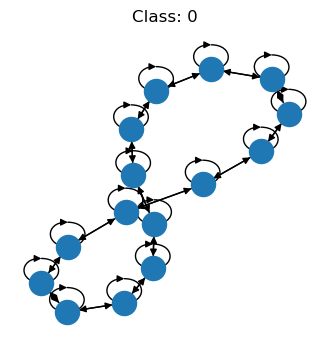

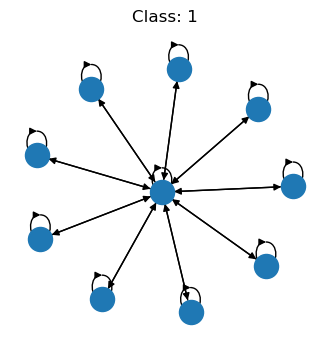

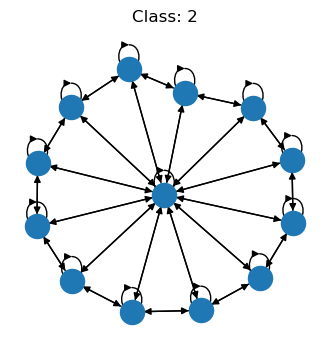

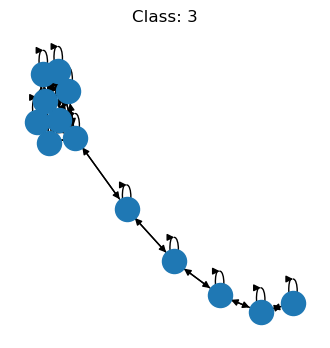

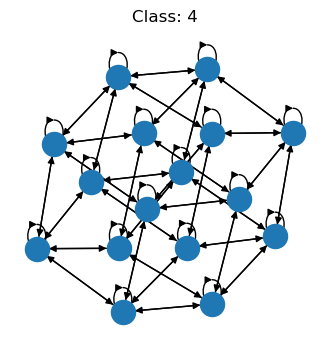

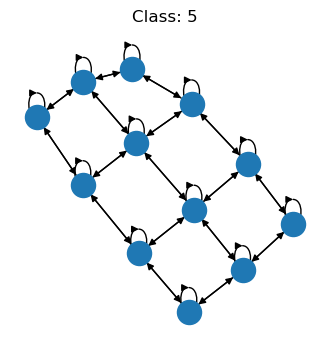

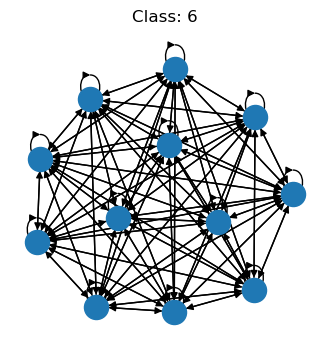

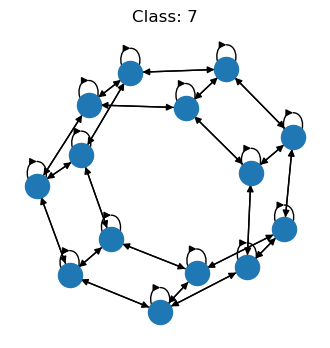

In [2]:
dataset = MiniGCDataset(8, 10, 20) # DGL artificial dataset

# visualise the 8 classes of graphs
for c in range(8):
    graph, label = dataset[c] 
    #fig, ax = plt.subplots()
    fig, ax = plt.subplots(figsize=(4,4))
    nx.draw(graph.to_networkx(), ax=ax)
    ax.set_title('Class: {:d}'.format(label))
    plt.show()


# Generate train, val and test datasets 


## Question 1: Add a node feature with the in-degree node 

Hints: You may use function `.in_degrees()`, `.view()`, `.float()`


In [3]:
# Add node features to graphs
def add_node_features(dataset):
    for (graph,_) in dataset:
        ########################################
        # YOUR CODE STARTS
        # node feature = node in-degree
        # graph.ndata['feat'].size()=(num_nodes,1) and graph.ndata['feat'].type()=torch.FloatTensor
        ########################################
        graph.ndata['feat'] = graph.in_degrees().view(-1, 1).float() # node feat is in-degree
        ########################################
        # YOUR CODE ENDS
        ########################################
    return dataset

# Generate graph datasets
trainset = MiniGCDataset(350, 10, 20)
testset = MiniGCDataset(100, 10, 20)
valset = MiniGCDataset(100, 10, 20)
trainset = add_node_features(trainset)
testset = add_node_features(testset)
valset = add_node_features(valset)
print(trainset[0])


(Graph(num_nodes=15, num_edges=45,
      ndata_schemes={'feat': Scheme(shape=(1,), dtype=torch.float32)}
      edata_schemes={}), tensor(0))


## Question 2: Define the collate function to generate a batch of DGL graphs and test it

Batch a collection of DGL graphs into one graph for more efficient computation.

Hints: You may use the DGL module [dgl.batch()](https://docs.dgl.ai/generated/dgl.batch.html#dgl.batch). 


In [4]:
# collate function prepares a batch of graphs and labels 
def collate(samples):
    # Input sample is a list of pairs (graph, label)
    graphs, labels = map(list, zip(*samples)) # "graphs" is a list of "batch_size" DGL graphs
                                              # "labels" is a list of "batch_size" class labels
    ########################################
    # YOUR CODE STARTS
    # Create the DGL batch of graphs, which is equivalent to build a block diagonal matrix with all graphs in the batch
    ########################################
    batch_graphs = dgl.batch(graphs)
    batch_labels = torch.tensor(labels)
    ########################################
    # YOUR CODE ENDS
    ########################################
    batch_labels = torch.tensor(labels) # batch of labels
    return batch_graphs, batch_labels

# Generate a batch of graphs
batch_size = 10
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, collate_fn=collate)
batch_graphs, batch_labels = list(train_loader)[0]
print(batch_graphs)
print(batch_labels)
batch_x = batch_graphs.ndata['feat']
print('batch_x:',batch_x.size())


Graph(num_nodes=145, num_edges=869,
      ndata_schemes={'feat': Scheme(shape=(1,), dtype=torch.float32)}
      edata_schemes={})
tensor([5, 7, 1, 6, 7, 7, 6, 0, 1, 7])
batch_x: torch.Size([145, 1])


## Question 3: Design the class of GCN networks with DGL

Node update equation:  

$$h_i^{(\ell+1)} = h_i^{(\ell)} + \text{ReLU}\left( \frac{1}{\sqrt{d_i}} \sum_{j \in \mathcal{N}(i)} \frac{1}{\sqrt{d_j}} W^{(\ell)} h_j^{(\ell)} \right)$$

Instructions:

Step 1: Pass node feature and edge features along edges (src/j => dst/i) in `message_func()`.
  - `edges.src['xx']` is to pick the feature 'xx' from the source nodes of edges.
    
Step 2: Send `reduce_func()` collects all messages={Whj, dj} to node dst/i with Step 1.
  - `nodes.mailbox['yy']` is to gather the feature 'yy' from neighbor nodes.
  

In [5]:
# MLP layer for classification
class MLP_layer(nn.Module): 
    
    def __init__(self, input_dim, output_dim, L=2): # L = nb of hidden layers
        super(MLP_layer, self).__init__()
        list_FC_layers = [ nn.Linear( input_dim, input_dim, bias=True ) for l in range(L) ]
        list_FC_layers.append(nn.Linear( input_dim, output_dim , bias=True ))
        self.FC_layers = nn.ModuleList(list_FC_layers)
        self.L = L
        
    def forward(self, x):
        y = x
        for l in range(self.L):
            y = self.FC_layers[l](y)
            y = torch.relu(y)
        y = self.FC_layers[self.L](y)
        return y

        
# class of GatedGCN layer  
class GCN_layer(nn.Module):
    
    def __init__(self, input_dim, output_dim):
        super(GCN_layer, self).__init__()
        self.W = nn.Linear(input_dim, output_dim, bias=True)
        
    # Step 1 of message-passing with DGL: 
    #   Node feature and edge features are passed along edges (src/j => dst/i) 
    def message_func(self, edges):
        ########################################
        # YOUR CODE STARTS
        # Step 1: Pass the messages Wh_j and d_j (in-degree_j) to the node i
        ########################################
        Whj = edges.src['Wh']
        dj = edges.src['d']
        ########################################
        # YOUR CODE ENDS
        ########################################
        return {'Whj' : Whj, 'dj' : dj}

    # Step 2 of message-passing with DGL: 
    #   Reduce function collects all messages={Whj, dj} sent to node dst/i with Step 1
    def reduce_func(self, nodes):
        ########################################
        # YOUR CODE STARTS
        # Step 2: Node i receives messages Wh_j and d_j (in-degree_j) 
        ########################################
        Whj = nodes.mailbox['Whj'] # shape=(num_nodes, num_neighbors, output_dim)
        dj = nodes.mailbox['dj'] # shape=(num_nodes, num_neighbors, 1)
        ########################################
        # YOUR CODE ENDS
        ########################################
        inv_sqrt_dj = torch.pow(dj, -0.5) # 1/sqrt(d_j)
        h = torch.sum( inv_sqrt_dj * Whj, dim=1 ) # hi = sum_j 1/sqrt(d_j) * Bhj 
        return {'h' : h} # return update node feature hi

    def forward(self, g, h):
        h_in = h # residual connection
        g.ndata['Wh'] = self.W(h) # linear transformation # shape=(num_nodes, output_dim)
        d = g.in_degrees().view(-1, 1).float() # in-degree d_i # shape=(num_nodes, 1)
        g.ndata['d'] = d 
        g.update_all(self.message_func,self.reduce_func) # update the node feature with DGL
        h = g.ndata['h'] # collect the node output of graph convolution # shape=(num_nodes, output_dim)
        inv_sqrt_d = torch.pow(d, -0.5) # 1/ sqrt(d_i)
        h = inv_sqrt_d * h # h_i / sqrt(d_i)
        h = torch.relu(h) # non-linear activation
        h = h_in + h # residual connection
        return h
    
    
class GCN_net(nn.Module):
    
    def __init__(self, net_parameters):
        super(GCN_net, self).__init__()
        input_dim = net_parameters['input_dim']
        hidden_dim = net_parameters['hidden_dim']
        output_dim = net_parameters['output_dim']
        L = net_parameters['L']
        self.embedding_h = nn.Linear(input_dim, hidden_dim)
        self.GCN_layers = nn.ModuleList([ GCN_layer(hidden_dim, hidden_dim) for _ in range(L) ]) 
        self.MLP_layer = MLP_layer(hidden_dim, output_dim)
        
    def forward(self, g, h):
        
        # input embedding
        h = self.embedding_h(h)
        
        # graph convnet layers
        for GCNlayer in self.GCN_layers:
            h = GCNlayer(g,h)
        
        # MLP classifier
        g.ndata['h'] = h
        y = dgl.mean_nodes(g,'h')
        y = self.MLP_layer(y)
        
        return y    
    
    def loss(self, y_scores, y_labels):
        loss = nn.CrossEntropyLoss()(y_scores, y_labels)
        return loss        
        
    def accuracy(self, scores, targets):
        scores = scores.detach().argmax(dim=1)
        acc = (scores==targets).float().sum().item()
        return acc
    
    def update(self, lr):       
        update = torch.optim.Adam( self.parameters(), lr=lr )
        return update


# Instantiate one network (testing)
net_parameters = {}
net_parameters['input_dim'] = 1
net_parameters['hidden_dim'] = 128
net_parameters['output_dim'] = 8 # nb of classes
net_parameters['L'] = 4
net = GCN_net(net_parameters)
print(net)

def display_num_param(net):
    nb_param = 0
    for param in net.parameters():
        nb_param += param.numel()
    print('Number of parameters: {} ({:.2f} million)'.format(nb_param, nb_param/1e6))
    return nb_param/1e6
_ = display_num_param(net)


GCN_net(
  (embedding_h): Linear(in_features=1, out_features=128, bias=True)
  (GCN_layers): ModuleList(
    (0-3): 4 x GCN_layer(
      (W): Linear(in_features=128, out_features=128, bias=True)
    )
  )
  (MLP_layer): MLP_layer(
    (FC_layers): ModuleList(
      (0-1): 2 x Linear(in_features=128, out_features=128, bias=True)
      (2): Linear(in_features=128, out_features=8, bias=True)
    )
  )
)
Number of parameters: 100360 (0.10 million)


# Train the network

In [6]:
def run_one_epoch(net, data_loader, train=True):
    if train:
        net.train()
    else:
        net.eval()
    epoch_loss = 0
    epoch_acc = 0
    nb_data = 0
    gpu_mem = 0
    for iter, (batch_graphs, batch_labels) in enumerate(data_loader):
        batch_x = batch_graphs.ndata['feat']
        batch_labels = batch_labels
        batch_scores = net.forward(batch_graphs, batch_x)
        loss = net.loss(batch_scores, batch_labels)
        if train:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        epoch_loss += loss.detach().item()
        epoch_acc += net.accuracy(batch_scores,batch_labels)
        nb_data += batch_labels.size(0)
    epoch_loss /= (iter + 1)
    epoch_acc /= nb_data
    return epoch_loss, epoch_acc 


# dataset loaders
train_loader = DataLoader(trainset, batch_size=50, shuffle=True, collate_fn=collate)
test_loader = DataLoader(testset, batch_size=50, shuffle=False, collate_fn=collate)
val_loader = DataLoader(valset, batch_size=50, shuffle=False, drop_last=False, collate_fn=collate)

# Instantiate one network
net_parameters = {}
net_parameters['input_dim'] = 1
net_parameters['hidden_dim'] = 128
net_parameters['output_dim'] = 8 # nb of classes
net_parameters['L'] = 4
net = GCN_net(net_parameters)
display_num_param(net)

# optimizer
optimizer = torch.optim.Adam(net.parameters(), lr=0.0001)

# training loop
for epoch in range(50):
    start = time.time()
    epoch_train_loss, epoch_train_acc = run_one_epoch(net, train_loader, True)
    with torch.no_grad(): 
        epoch_test_loss, epoch_test_acc = run_one_epoch(net, test_loader, False)
        epoch_val_loss, epoch_val_acc = run_one_epoch(net, val_loader, False)  
    print('Epoch {}, time {:.4f}, train_loss: {:.4f}, test_loss: {:.4f}, val_loss: {:.4f}'.format(epoch, time.time()-start, epoch_train_loss, epoch_test_loss, epoch_val_loss))
    print('                      train_acc: {:.4f}, test_acc: {:.4f}, val_acc: {:.4f}'.format(epoch_train_acc, epoch_test_acc, epoch_val_acc))
    

Number of parameters: 100360 (0.10 million)


c:\Users\64483\miniconda3\envs\gnn_course\lib\site-packages\dgl\backend\pytorch\tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


Epoch 0, time 1.6446, train_loss: 2.0324, test_loss: 1.9854, val_loss: 1.9854
                      train_acc: 0.1229, test_acc: 0.1200, val_acc: 0.1200
Epoch 1, time 1.7329, train_loss: 1.9456, test_loss: 1.9428, val_loss: 1.9428
                      train_acc: 0.1257, test_acc: 0.1200, val_acc: 0.1200
Epoch 1, time 1.7329, train_loss: 1.9456, test_loss: 1.9428, val_loss: 1.9428
                      train_acc: 0.1257, test_acc: 0.1200, val_acc: 0.1200
Epoch 2, time 1.6694, train_loss: 1.9169, test_loss: 1.9262, val_loss: 1.9262
                      train_acc: 0.1229, test_acc: 0.1200, val_acc: 0.1200
Epoch 2, time 1.6694, train_loss: 1.9169, test_loss: 1.9262, val_loss: 1.9262
                      train_acc: 0.1229, test_acc: 0.1200, val_acc: 0.1200
Epoch 3, time 1.5970, train_loss: 1.9115, test_loss: 1.9131, val_loss: 1.9131
                      train_acc: 0.1229, test_acc: 0.1200, val_acc: 0.1200
Epoch 3, time 1.5970, train_loss: 1.9115, test_loss: 1.9131, val_loss: 1.9131
    

# --------------------------------------------------------------------------------
# Code03 Exercise
# --------------------------------------------------------------------------------


# Lecture : Graph Convolutional Networks

## Lab 03 : GAT -- Exercise

### Xavier Bresson, Nian Liu

Velickovic, Cucurull, Casanova, Romero, Lio, Bengio, Graph Attention Networks, 2017      
https://arxiv.org/pdf/1710.10903


In [ ]:
# For Google Colaboratory
import sys, os
if 'google.colab' in sys.modules:
    # mount google drive
    from google.colab import drive
    drive.mount('/content/gdrive')
    path_to_file = '/content/gdrive/My Drive/CS5284_2025_codes/codes/08_Graph_Convnets'
    print(path_to_file)
    # change current path to the folder containing "path_to_file"
    os.chdir(path_to_file)
    !pwd
    !pip install dgl==1.0.0 # Install DGL
    

In [1]:
# Libraries
import dgl
from dgl.data import MiniGCDataset
import matplotlib.pyplot as plt
import networkx as nx
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import time


# Visualize the artifical graph dataset used in this notebook

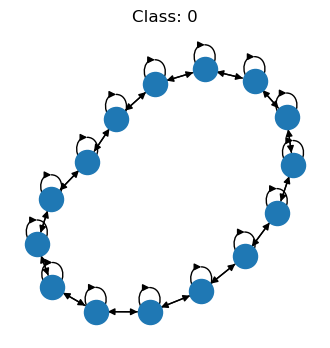

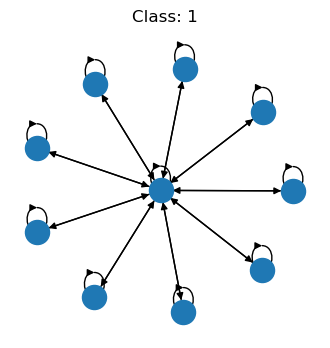

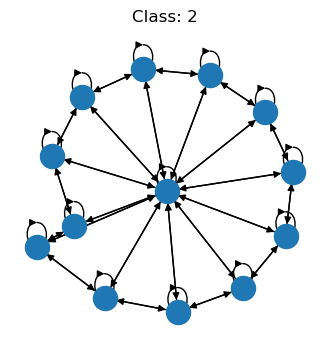

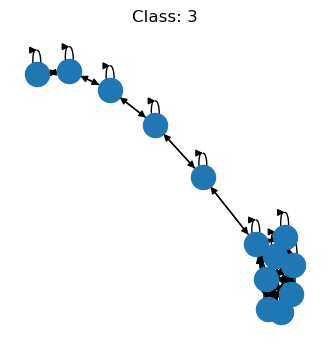

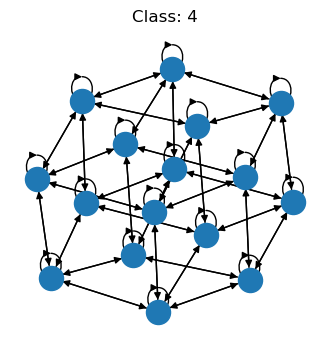

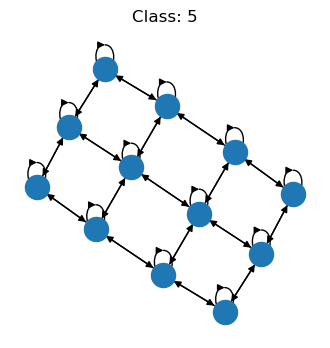

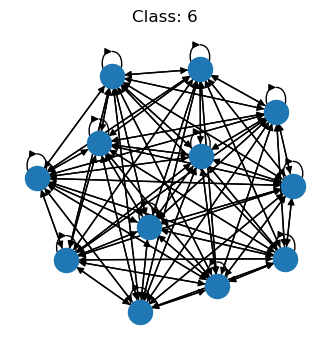

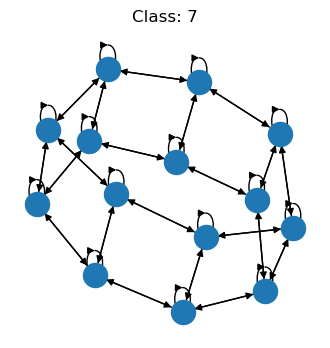

In [2]:
dataset = MiniGCDataset(8, 10, 20) # DGL artificial dataset

# visualise the 8 classes of graphs
for c in range(8):
    graph, label = dataset[c] 
    #fig, ax = plt.subplots()
    fig, ax = plt.subplots(figsize=(4,4))
    nx.draw(graph.to_networkx(), ax=ax)
    ax.set_title('Class: {:d}'.format(label))
    plt.show()


# Generate train, val and test datasets 

## Add node feature

In [3]:
# Add node features to graphs
def add_node_features(dataset):
    for (graph,_) in dataset:
        # node feature = node in-degree
        graph.ndata['feat'] = graph.in_degrees().view(-1, 1).float() # node feat is in-degree
    return dataset

# Generate graph datasets
trainset = MiniGCDataset(350, 10, 20)
testset = MiniGCDataset(100, 10, 20)
valset = MiniGCDataset(100, 10, 20)
trainset = add_node_features(trainset)
testset = add_node_features(testset)
valset = add_node_features(valset)
print(trainset[0])


(Graph(num_nodes=15, num_edges=45,
      ndata_schemes={'feat': Scheme(shape=(1,), dtype=torch.float32)}
      edata_schemes={}), tensor(0))


# Define the collate function to prepare a batch of DGL graphs and test it

In [4]:
# collate function prepares a batch of graphs and labels 
def collate(samples):
    # Input sample is a list of pairs (graph, label)
    graphs, labels = map(list, zip(*samples)) # "graphs" is a list of "batch_size" DGL graphs
                                              # "labels" is a list of "batch_size" class labels
    # Create the DGL batch of graphs, which is equivalent to build a block diagonal matrix with all graphs in the batch
    batch_graphs = dgl.batch(graphs)    # batch of graphs
    batch_labels = torch.tensor(labels) # batch of labels
    return batch_graphs, batch_labels

# Generate a batch of graphs
batch_size = 10
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, collate_fn=collate)
batch_graphs, batch_labels = list(train_loader)[0]
print(batch_graphs)
print(batch_labels)
batch_x = batch_graphs.ndata['feat']
print('batch_x:',batch_x.size())


Graph(num_nodes=146, num_edges=1324,
      ndata_schemes={'feat': Scheme(shape=(1,), dtype=torch.float32)}
      edata_schemes={})
tensor([6, 5, 3, 4, 6, 1, 3, 3, 7, 6])
batch_x: torch.Size([146, 1])


## Question 1: Design the class of GAT networks with DGL

Update equations:  

$$h_{i}^{\ell+1} = \text{Concat}_{k=1}^{K} \left( \text{ELU} \left( \sum_{j \in \mathcal{N}_i} e_{ij}^{k,\ell} W_1^{k,\ell} h_{j}^{\ell} \right) \right)$$

$$e_{ij}^{k,\ell} = \text{Softmax}_{\mathcal{N}_i}(\hat{e}_{ij}^{k,\ell}) = \frac{\exp(\hat{e}_{ij}^{k,\ell})}{\sum_{j' \in \mathcal{N}_i} \exp(\hat{e}_{ij'}^{k,\ell})}$$

$$\hat{e}_{ij}^{k,\ell} = \text{LeakyReLU} \left( W_2^{k,\ell} \text{Concat} \left( W_1^{k,\ell}h_{i}^{\ell} , W_1^{k,\ell}h_{j}^{\ell} \right) \right)$$

Instructions:

Step 1: Define an attention head layer
- Pass node feature and edge features along edges (src/j => dst/i) in `message_func()`.
- Calculate the unnormalized attentions between srd and des nodes $\hat e_{ij}^{k,\ell}$.
- Use `reduce_func()` to collect all messages={eij, Whj} sent to node dst/i with Step 1.
- Normalize attentions within neighbors, and sum over `Whj` weighted by normalized attentions $e_{ij}^{k,\ell}$.

Step 2: Define a multiple attention head layer
- Use Step 1 multiple times to get the multi-head attention in GAT.
- Each head is expected to capture a distinct similarity property between nodes.


In [5]:
# MLP layer for classification
class MLP_layer(nn.Module): 
    
    def __init__(self, input_dim, output_dim, L=2): # L = nb of hidden layers
        super(MLP_layer, self).__init__()
        list_FC_layers = [ nn.Linear( input_dim, input_dim, bias=True ) for l in range(L) ]
        list_FC_layers.append(nn.Linear( input_dim, output_dim , bias=True ))
        self.FC_layers = nn.ModuleList(list_FC_layers)
        self.L = L
        
    def forward(self, x):
        y = x
        for l in range(self.L):
            y = self.FC_layers[l](y)
            y = torch.relu(y)
        y = self.FC_layers[self.L](y)
        return y


class GAT_one_head(nn.Module):  
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.W = nn.Linear(input_dim, output_dim, bias=True)
        self.a = nn.Linear(2*output_dim, 1, bias=False)
        
    # Step 1 of message-passing with DGL: 
    #   Node feature and edge features are passed along edges (src/j => dst/i) 
    def message_func(self, edges):
        ########################################
        # YOUR CODE STARTS
        # Step 1: Calculate unnormalized attention between i and j as edge feature of `eij`, store `eij` as well as `Whj` for `reduce_func`
        ########################################
        Whi = edges.dst['Wh'] # shape=(num_edges, output_dim)
        Whj = edges.src['Wh'] # shape=(num_edges, output_dim)
        WhiWhj = torch.cat( [Whi, Whj], dim=1 ) # shape=(num_edges, 2*output_dim)
        aWhiWhj = self.a(WhiWhj) # shape=(num_edges, 1)
        eij = nn.LeakyReLU()(aWhiWhj) # shape=(num_edges, 1) # this is eij hat in the equation above
        ########################################
        # YOUR CODE ENDS
        ########################################
        return {'eij' : eij, 'Whj' : Whj} # send message={Bhj, eij} to node dst/i

    # Step 2 of message-passing with DGL: 
    #   Reduce function collects all messages={Whj} sent to node dst/i with Step 1
    def reduce_func(self, nodes):
        ########################################
        # YOUR CODE STARTS
        # Step 2: Normalize `eij`, and weight `Whj` to get updated features for src nodes `h`
        ########################################
        eij = nodes.mailbox['eij'] # shape=(num_nodes, num_neighbors, 1)
        Whj = nodes.mailbox['Whj'] # shape=(num_nodes, num_neighbors, output_dim)
        exp_eij = torch.exp(eij) # shape=(num_nodes, num_neighbors, 1) # unnormalized attention
        h = torch.sum(exp_eij * Whj, dim=1) / torch.sum( exp_eij, dim=1 ) # hi = Ahi + sum_j eta_ij * Bhj # updated node feature
        ########################################
        # YOUR CODE ENDS
        ########################################
        return {'h' : h} # return update node feature hi
    
    def forward(self, g, h):
        g.ndata['Wh'] = self.W(h) # linear transformation # shape=(num_nodes, output_dim)
        g.update_all(self.message_func,self.reduce_func) # update the node feature with DGL
        h = g.ndata['h'] # collect the node output of graph convolution # shape=(num_nodes, output_dim)
        h = nn.ELU()(h) # non-linear activation
        return h


class GAT_layer(nn.Module):
    
    def __init__(self, input_dim, num_heads, output_dim):
        super().__init__()
        self.GAT_one_heads = nn.ModuleList( [GAT_one_head(input_dim, output_dim) for _ in range(num_heads)] )
        
    def forward(self, g, h):
        h_in = h # residual connection
        list_h = []
        ########################################
        # YOUR CODE STARTS
        # Step 3: Concatenate results from each head, then give the multi-head attention based output
        ########################################
        for gat_head in self.GAT_one_heads:
            h_head = gat_head(g,h)
            list_h.append(h_head)
        h = torch.cat(list_h, dim=1) # concatenate along feature dimension
        ########################################
        # YOUR CODE ENDS
        ########################################
        # print('h',h.size())
        return h
    

class GAT_net(nn.Module):
    
    def __init__(self, net_parameters):
        super().__init__()
        input_dim = net_parameters['input_dim']
        num_heads = net_parameters['num_heads']
        hidden_dim = net_parameters['hidden_dim']
        output_dim = net_parameters['output_dim']
        L = net_parameters['L']
        self.embedding_h = nn.Linear(input_dim, hidden_dim)
        self.GAT_layers = nn.ModuleList([ GAT_layer(hidden_dim, num_heads, hidden_dim//num_heads) for _ in range(L) ]) 
        self.MLP_layer = MLP_layer(hidden_dim, output_dim)
        
    def forward(self, g, h):
        
        # input embedding
        h = self.embedding_h(h)
        
        # graph convnet layers
        for GATlayer in self.GAT_layers:
            h = GATlayer(g,h)
        
        # MLP classifier
        g.ndata['h'] = h
        y = dgl.mean_nodes(g,'h')
        y = self.MLP_layer(y)
        
        return y    
    
    def loss(self, y_scores, y_labels):
        loss = nn.CrossEntropyLoss()(y_scores, y_labels)
        return loss        
        
    def accuracy(self, scores, targets):
        scores = scores.detach().argmax(dim=1)
        acc = (scores==targets).float().sum().item()
        return acc
    
    def update(self, lr):       
        update = torch.optim.Adam( self.parameters(), lr=lr )
        return update


# Instantiate one network (testing)
net_parameters = {}
net_parameters['input_dim'] = 1
net_parameters['num_heads'] = 4
net_parameters['hidden_dim'] = net_parameters['num_heads'] * 32
net_parameters['output_dim'] = 8 # nb of classes
net_parameters['L'] = 4
net = GAT_net(net_parameters)
print(net)

def display_num_param(net):
    nb_param = 0
    for param in net.parameters():
        nb_param += param.numel()
    print('Number of parameters: {} ({:.2f} million)'.format(nb_param, nb_param/1e6))
    return nb_param/1e6
display_num_param(net)

train_loader = DataLoader(trainset, batch_size=50, shuffle=True, collate_fn=collate)
batch_x = batch_graphs.ndata['feat']
batch_labels = batch_labels
batch_scores = net(batch_graphs, batch_x)



GAT_net(
  (embedding_h): Linear(in_features=1, out_features=128, bias=True)
  (GAT_layers): ModuleList(
    (0-3): 4 x GAT_layer(
      (GAT_one_heads): ModuleList(
        (0-3): 4 x GAT_one_head(
          (W): Linear(in_features=128, out_features=32, bias=True)
          (a): Linear(in_features=64, out_features=1, bias=False)
        )
      )
    )
  )
  (MLP_layer): MLP_layer(
    (FC_layers): ModuleList(
      (0-1): 2 x Linear(in_features=128, out_features=128, bias=True)
      (2): Linear(in_features=128, out_features=8, bias=True)
    )
  )
)
Number of parameters: 101384 (0.10 million)


c:\Users\64483\miniconda3\envs\gnn_course\lib\site-packages\dgl\backend\pytorch\tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


# Train the network

In [6]:
def run_one_epoch(net, data_loader, train=True):
    if train:
        net.train()
    else:
        net.eval()
    epoch_loss = 0
    epoch_acc = 0
    nb_data = 0
    gpu_mem = 0
    for iter, (batch_graphs, batch_labels) in enumerate(data_loader):
        batch_x = batch_graphs.ndata['feat']
        batch_labels = batch_labels
        batch_scores = net.forward(batch_graphs, batch_x)
        loss = net.loss(batch_scores, batch_labels)
        if train:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        epoch_loss += loss.detach().item()
        epoch_acc += net.accuracy(batch_scores,batch_labels)
        nb_data += batch_labels.size(0)
    epoch_loss /= (iter + 1)
    epoch_acc /= nb_data
    return epoch_loss, epoch_acc 


# dataset loaders
train_loader = DataLoader(trainset, batch_size=50, shuffle=True, collate_fn=collate)
test_loader = DataLoader(testset, batch_size=50, shuffle=False, collate_fn=collate)
val_loader = DataLoader(valset, batch_size=50, shuffle=False, drop_last=False, collate_fn=collate)

# Instantiate one network
net_parameters = {}
net_parameters['input_dim'] = 1
net_parameters['num_heads'] = 4
net_parameters['hidden_dim'] = net_parameters['num_heads'] * 32
net_parameters['output_dim'] = 8 # nb of classes
net_parameters['L'] = 4
net = GAT_net(net_parameters)
display_num_param(net)

# optimizer
optimizer = torch.optim.Adam(net.parameters(), lr=0.0001)

# training loop
for epoch in range(50):
    start = time.time()
    epoch_train_loss, epoch_train_acc = run_one_epoch(net, train_loader, True)
    with torch.no_grad(): 
        epoch_test_loss, epoch_test_acc = run_one_epoch(net, test_loader, False)
        epoch_val_loss, epoch_val_acc = run_one_epoch(net, val_loader, False)  
    if not epoch%2:
        print('Epoch {}, time {:.4f}, train_loss: {:.4f}, test_loss: {:.4f}, val_loss: {:.4f}'.format(epoch, time.time()-start, epoch_train_loss, epoch_test_loss, epoch_val_loss))
        print('                      train_acc: {:.4f}, test_acc: {:.4f}, val_acc: {:.4f}'.format(epoch_train_acc, epoch_test_acc, epoch_val_acc))
    

Number of parameters: 101384 (0.10 million)
Epoch 0, time 6.2341, train_loss: 2.0782, test_loss: 2.0716, val_loss: 2.0716
                      train_acc: 0.1229, test_acc: 0.1200, val_acc: 0.1200
Epoch 2, time 6.1331, train_loss: 2.0595, test_loss: 2.0551, val_loss: 2.0551
                      train_acc: 0.1229, test_acc: 0.1200, val_acc: 0.1200
Epoch 4, time 6.3966, train_loss: 2.0350, test_loss: 2.0271, val_loss: 2.0271
                      train_acc: 0.1829, test_acc: 0.1700, val_acc: 0.1700
Epoch 6, time 6.3178, train_loss: 1.9865, test_loss: 1.9753, val_loss: 1.9753
                      train_acc: 0.2029, test_acc: 0.1700, val_acc: 0.1700
Epoch 8, time 6.5475, train_loss: 1.9015, test_loss: 1.8855, val_loss: 1.8855
                      train_acc: 0.2314, test_acc: 0.2900, val_acc: 0.2900
Epoch 10, time 6.4223, train_loss: 1.7861, test_loss: 1.7733, val_loss: 1.7733
                      train_acc: 0.2800, test_acc: 0.2900, val_acc: 0.2900
Epoch 12, time 6.6863, train_loss: 1.

# --------------------------------------------------------------------------------
# Code04 Exercise
# --------------------------------------------------------------------------------


# Lecture : Graph Convolutional Networks

## Lab 04 : GatedGCNs -- Exercise

### Xavier Bresson, Nian Liu

Bresson, Laurent, Residual Gated Graph ConvNets, 2017  
https://arxiv.org/pdf/1711.07553


In [ ]:
# For Google Colaboratory
import sys, os
if 'google.colab' in sys.modules:
    # mount google drive
    from google.colab import drive
    drive.mount('/content/gdrive')
    path_to_file = '/content/gdrive/My Drive/CS5284_2025_codes/codes/08_Graph_Convnets'
    print(path_to_file)
    # change current path to the folder containing "path_to_file"
    os.chdir(path_to_file)
    !pwd
    !pip install dgl==1.0.0 # Install DGL
    

In [1]:
# Libraries
import dgl
from dgl.data import MiniGCDataset
import matplotlib.pyplot as plt
import networkx as nx
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import time


# Visualize the artifical graph dataset used in this notebook

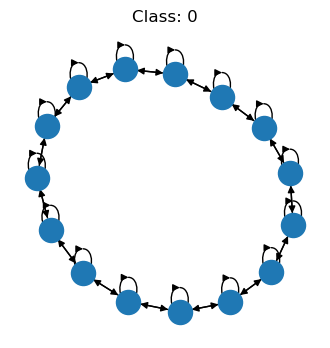

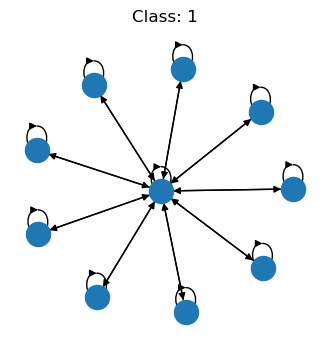

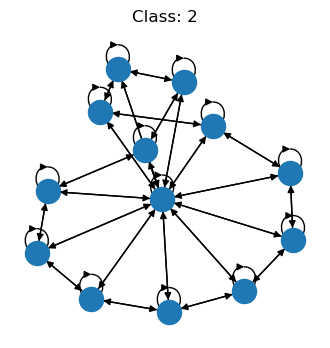

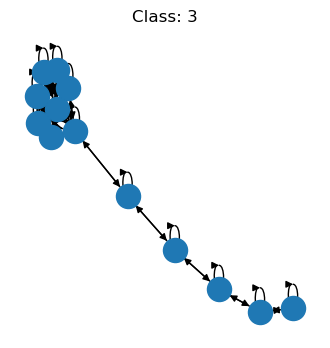

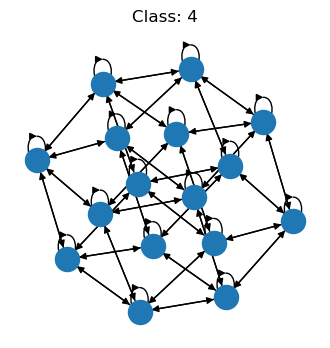

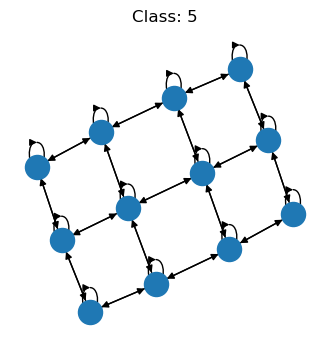

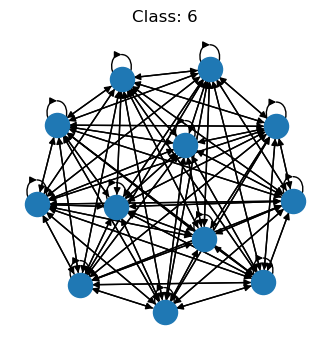

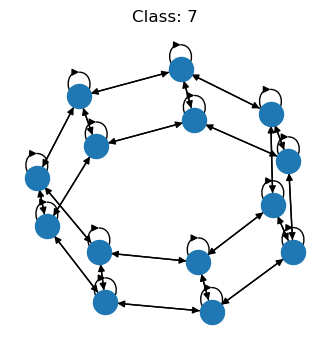

In [2]:
dataset = MiniGCDataset(8, 10, 20) # DGL artificial dataset

# visualise the 8 classes of graphs
for c in range(8):
    graph, label = dataset[c] 
    #fig, ax = plt.subplots()
    fig, ax = plt.subplots(figsize=(4,4))
    nx.draw(graph.to_networkx(), ax=ax)
    ax.set_title('Class: {:d}'.format(label))
    plt.show()


# Generate train, val and test datasets 

## Add node and edge features

In [3]:
# Add node and edge features to graphs
def add_node_edge_features(dataset):
    for (graph,_) in dataset:
        graph.ndata['feat'] = graph.in_degrees().view(-1, 1).float() # node feature is node in-degree
        graph.edata['feat'] = torch.ones(graph.number_of_edges(),1)  # edge feature is scalar 1 (no edge info available but an input edge value is needed for edge feature update)
    return dataset

# Generate graph datasets
trainset = MiniGCDataset(350, 10, 20)
testset = MiniGCDataset(100, 10, 20)
valset = MiniGCDataset(100, 10, 20)
trainset = add_node_edge_features(trainset)
testset = add_node_edge_features(testset)
valset = add_node_edge_features(valset)
print(trainset[0])


(Graph(num_nodes=15, num_edges=45,
      ndata_schemes={'feat': Scheme(shape=(1,), dtype=torch.float32)}
      edata_schemes={'feat': Scheme(shape=(1,), dtype=torch.float32)}), tensor(0))


# Define the collate function to prepare a batch of DGL graphs and test it

In [4]:
# collate function prepares a batch of graphs, labels and other graph features (if needed)
def collate(samples):
    
    # Input sample is a list of pairs (graph, label)
    graphs, labels = map(list, zip(*samples))
    batch_graphs = dgl.batch(graphs)    # batch of graphs
    batch_labels = torch.tensor(labels) # batch of labels (here class label)
    
    # Normalization w.r.t. graph sizes
    tab_sizes_n = [ graphs[i].number_of_nodes() for i in range(len(graphs))]
    tab_norm_n = [ torch.FloatTensor(size,1).fill_(1./float(size)) for size in tab_sizes_n ]
    batch_norm_n = torch.cat(tab_norm_n).sqrt()  
    tab_sizes_e = [ graphs[i].number_of_edges() for i in range(len(graphs))]
    tab_norm_e = [ torch.FloatTensor(size,1).fill_(1./float(size)) for size in tab_sizes_e ]
    batch_norm_e = torch.cat(tab_norm_e).sqrt()
    
    return batch_graphs, batch_labels, batch_norm_n, batch_norm_e


# Generate a batch of graphs
batch_size = 10
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, collate_fn=collate)
batch_graphs, batch_labels, batch_norm_n, batch_norm_e = list(train_loader)[0]
print(batch_graphs)
print(batch_labels)
print('batch_norm_n:',batch_norm_n.size())
print('batch_norm_e:',batch_norm_e.size())
batch_x = batch_graphs.ndata['feat']
print('batch_x:',batch_x.size())
batch_e = batch_graphs.edata['feat']
print('batch_e:',batch_e.size())


Graph(num_nodes=142, num_edges=926,
      ndata_schemes={'feat': Scheme(shape=(1,), dtype=torch.float32)}
      edata_schemes={'feat': Scheme(shape=(1,), dtype=torch.float32)})
tensor([3, 0, 2, 0, 6, 5, 5, 1, 7, 2])
batch_norm_n: torch.Size([142, 1])
batch_norm_e: torch.Size([926, 1])
batch_x: torch.Size([142, 1])
batch_e: torch.Size([926, 1])


## Question 1: Design the class of GatedGCN networks with DGL

Node and edge update equations:  

**Node Update:**
$$h_i^{\ell+1} = h_i^{\ell} + \text{ReLU} \left( \text{BN} \left( A^\ell h_i^{\ell} +  \sum_{j \sim i} \eta(e_{ij}^{\ell}) \odot B^\ell h_j^{\ell} \right) \right)$$

**Gating Function:**
$$\eta(e_{ij}^{\ell}) = \frac{\sigma(e_{ij}^{\ell})}{\sum_{j' \sim i} \sigma(e_{ij'}^{\ell}) + \varepsilon}$$

**Edge Update:**
$$e_{ij}^{\ell+1} = e_{ij}^{\ell} + \text{ReLU} \left( \text{BN} \left( C^\ell e_{ij}^{\ell} + D^\ell h_i^{\ell} + E^\ell h_j^{\ell} \right) \right)$$

Instructions:

Step 1: Pass node feature and edge features along edges (src/j => dst/i) in `message_func()`.
  - Collect the updated message for `eij`: $C^\ell e_{ij}^{\ell} + D^\ell h^{\ell}_i + E^\ell h^{\ell}_j$.

Step 2: Apply `reduce_func()` to collect all messages={eij, Bhj} sent to node dst/i with Step 1.
  - Prepare the updated message for `hi`: $A^\ell h_i^{\ell} +  \sum_{j\sim i} \eta(e_{ij}^{\ell}) \odot B^\ell h_j^{\ell}$.

Step 3: Finish the update for both `hi` and `eij`.



In [7]:
# MLP layer for classification
class MLP_layer(nn.Module): 
    
    def __init__(self, input_dim, output_dim, L=2): # L = nb of hidden layers
        super(MLP_layer, self).__init__()
        list_FC_layers = [ nn.Linear( input_dim, input_dim, bias=True ) for l in range(L) ]
        list_FC_layers.append(nn.Linear( input_dim, output_dim , bias=True ))
        self.FC_layers = nn.ModuleList(list_FC_layers)
        self.L = L
        
    def forward(self, x):
        y = x
        for l in range(self.L):
            y = self.FC_layers[l](y)
            y = torch.relu(y)
        y = self.FC_layers[self.L](y)
        return y

        
# class of GatedGCN layer  
class GatedGCN_layer(nn.Module):
    
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.A = nn.Linear(input_dim, output_dim, bias=True)
        self.B = nn.Linear(input_dim, output_dim, bias=True)
        self.C = nn.Linear(input_dim, output_dim, bias=True)
        self.D = nn.Linear(input_dim, output_dim, bias=True)
        self.E = nn.Linear(input_dim, output_dim, bias=True)
        self.bn_node_h = nn.BatchNorm1d(output_dim)
        self.bn_node_e = nn.BatchNorm1d(output_dim)

    # Step 1 of message-passing with DGL: 
    #   Node feature and edge features are passed along edges (src/j => dst/i) 
    def message_func(self, edges):
        ########################################
        # YOUR CODE START
        # Step 1: Calculate message for `eij`, simultaneously consider `eij`, `hi` and `hj`, store `eij` as well as `Bhj` for `reduce_func
        ########################################
        Bhj = edges.src['Bh']
        eij = edges.data['Ce'] + edges.dst['Dh'] + edges.src['Eh'] # Ceij + Dhi + Ehj with dst/i, src/j
        ########################################
        # YOUR CODE END
        ########################################
        edges.data['e'] = eij # update edge feature value
        return {'Bhj' : Bhj, 'eij' : eij} # send message={Bhj, eij} to node dst/i

    # Step 2 of message-passing with DGL: 
    #   Reduce function collects all messages={Bhj, eij} sent to node dst/i with Step 1
    def reduce_func(self, nodes):
        ########################################
        # YOUR CODE START
        # Step 2: Calculate message for `hi`, simultaneously consider `hj`, which is weighted by normalized `eij`
        ########################################
        Ahi = nodes.data['Ah']
        Bhj = nodes.mailbox['Bhj']
        e = nodes.mailbox['eij']
        sigmaij = torch.sigmoid(e)
        h = Ahi + torch.sum(sigmaij * Bhj, dim=1)
        ########################################
        # YOUR CODE END
        ########################################
        return {'h' : h} # return update node feature hi
    
    def forward(self, g, h, e, snorm_n, snorm_e):
        
        h_in = h # residual connection
        e_in = e # residual connection
        
        g.ndata['h']  = h 
        g.ndata['Ah'] = self.A(h) # linear transformation 
        g.ndata['Bh'] = self.B(h) # linear transformation 
        g.ndata['Dh'] = self.D(h) # linear transformation 
        g.ndata['Eh'] = self.E(h) # linear transformation 
        g.edata['e']  = e 
        g.edata['Ce'] = self.C(e) # linear transformation 
        
        g.update_all(self.message_func,self.reduce_func) # update the node and edge features with DGL
        
        h = g.ndata['h'] # collect the node output of graph convolution
        e = g.edata['e'] # collect the edge output of graph convolution
        
        h = h* snorm_n # normalize activation w.r.t. graph node size
        e = e* snorm_e # normalize activation w.r.t. graph edge size
        
        ########################################
        # YOUR CODE START
        # Step 3: batch_norm -> relu -> residual connection
        ########################################
        h = self.bn_node_h(h) # batch normalization  
        e = self.bn_node_e(e)# batch normalization  

        h = torch.relu(h) # non-linear activation
        e = torch.relu(e) # non-linear activation

        h = h + h_in # residual connection
        e = e + e_in # residual connection  
        ########################################
        # YOUR CODE END
        ########################################
        
        return h, e
    
    
class GatedGCN_net(nn.Module):
    
    def __init__(self, net_parameters):
        super(GatedGCN_net, self).__init__()
        input_dim = net_parameters['input_dim']
        hidden_dim = net_parameters['hidden_dim']
        output_dim = net_parameters['output_dim']
        L = net_parameters['L']
        self.embedding_h = nn.Linear(input_dim, hidden_dim)
        self.embedding_e = nn.Linear(1, hidden_dim)
        self.GatedGCN_layers = nn.ModuleList([ GatedGCN_layer(hidden_dim, hidden_dim) for _ in range(L) ]) 
        self.MLP_layer = MLP_layer(hidden_dim, output_dim)
        
    def forward(self, g, h, e, snorm_n, snorm_e):
        
        # input embedding
        h = self.embedding_h(h)
        e = self.embedding_e(e)
        
        # graph convnet layers
        for GGCN_layer in self.GatedGCN_layers:
            h,e = GGCN_layer(g,h,e,snorm_n,snorm_e)
        
        # MLP classifier
        g.ndata['h'] = h
        y = dgl.mean_nodes(g,'h') # DGL mean function over the neighbors
        y = self.MLP_layer(y)
        
        return y    
    
    def loss(self, y_scores, y_labels):
        loss = nn.CrossEntropyLoss()(y_scores, y_labels)
        return loss        
        
    def accuracy(self, scores, targets):
        scores = scores.detach().argmax(dim=1)
        acc = (scores==targets).float().sum().item()
        return acc
    
    def update(self, lr):       
        update = torch.optim.Adam( self.parameters(), lr=lr )
        return update


# Instantiate one network (testing)
net_parameters = {}
net_parameters['input_dim'] = 1
net_parameters['hidden_dim'] = 128
net_parameters['output_dim'] = 8 # nb of classes
net_parameters['L'] = 4
net = GatedGCN_net(net_parameters)
print(net)

def display_num_param(net):
    nb_param = 0
    for param in net.parameters():
        nb_param += param.numel()
    print('Number of parameters: {} ({:.2f} million)'.format(nb_param, nb_param/1e6))
    return nb_param/1e6
_ = display_num_param(net)


GatedGCN_net(
  (embedding_h): Linear(in_features=1, out_features=128, bias=True)
  (embedding_e): Linear(in_features=1, out_features=128, bias=True)
  (GatedGCN_layers): ModuleList(
    (0-3): 4 x GatedGCN_layer(
      (A): Linear(in_features=128, out_features=128, bias=True)
      (B): Linear(in_features=128, out_features=128, bias=True)
      (C): Linear(in_features=128, out_features=128, bias=True)
      (D): Linear(in_features=128, out_features=128, bias=True)
      (E): Linear(in_features=128, out_features=128, bias=True)
      (bn_node_h): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn_node_e): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (MLP_layer): MLP_layer(
    (FC_layers): ModuleList(
      (0-1): 2 x Linear(in_features=128, out_features=128, bias=True)
      (2): Linear(in_features=128, out_features=8, bias=True)
    )
  )
)
Number of parameters: 366856 (0.37 million)


# Train the network

In [8]:
def run_one_epoch(net, data_loader, train=True):
    if train:
        net.train() # during training
    else:
        net.eval()  # during inference/test
    epoch_loss = 0
    epoch_acc = 0
    nb_data = 0
    gpu_mem = 0
    for iter, (batch_graphs, batch_labels, batch_snorm_n, batch_snorm_e) in enumerate(data_loader):
        batch_x = batch_graphs.ndata['feat']
        batch_e = batch_graphs.edata['feat']
        batch_snorm_n = batch_snorm_n
        batch_snorm_e = batch_snorm_e
        batch_labels = batch_labels
        batch_scores = net.forward(batch_graphs, batch_x, batch_e, batch_snorm_n, batch_snorm_e)
        loss = net.loss(batch_scores, batch_labels)
        if train: # during training, run backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        epoch_loss += loss.detach().item()
        epoch_acc += net.accuracy(batch_scores,batch_labels)
        nb_data += batch_labels.size(0)
    epoch_loss /= (iter + 1)
    epoch_acc /= nb_data
    return epoch_loss, epoch_acc 


# dataset loaders
train_loader = DataLoader(trainset, batch_size=50, shuffle=True, collate_fn=collate)
test_loader = DataLoader(testset, batch_size=50, shuffle=False, collate_fn=collate)
val_loader = DataLoader(valset, batch_size=50, shuffle=False, drop_last=False, collate_fn=collate)

# Instantiate one network
net_parameters = {}
net_parameters['input_dim'] = 1
net_parameters['hidden_dim'] = 128
net_parameters['output_dim'] = 8 # nb of classes
net_parameters['L'] = 4
net = GatedGCN_net(net_parameters)
display_num_param(net)

# optimizer
optimizer = torch.optim.Adam(net.parameters(), lr=0.0001)

# training loop
for epoch in range(50):
    start = time.time()
    epoch_train_loss, epoch_train_acc = run_one_epoch(net, train_loader, True)
    with torch.no_grad(): 
        epoch_test_loss, epoch_test_acc = run_one_epoch(net, test_loader, False)
        epoch_val_loss, epoch_val_acc = run_one_epoch(net, val_loader, False)  
    if not epoch%2:
        print('Epoch {}, time {:.4f}, train_loss: {:.4f}, test_loss: {:.4f}, val_loss: {:.4f}'.format(epoch, time.time()-start, epoch_train_loss, epoch_test_loss, epoch_val_loss))
        print('                      train_acc: {:.4f}, test_acc: {:.4f}, val_acc: {:.4f}'.format(epoch_train_acc, epoch_test_acc, epoch_val_acc))
    

Number of parameters: 366856 (0.37 million)


c:\Users\64483\miniconda3\envs\gnn_course\lib\site-packages\dgl\backend\pytorch\tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


Epoch 0, time 2.5059, train_loss: 2.0195, test_loss: 1.9490, val_loss: 1.9490
                      train_acc: 0.1743, test_acc: 0.2400, val_acc: 0.2400
Epoch 2, time 2.7572, train_loss: 1.7436, test_loss: 1.8322, val_loss: 1.8322
                      train_acc: 0.4343, test_acc: 0.3200, val_acc: 0.3200
Epoch 2, time 2.7572, train_loss: 1.7436, test_loss: 1.8322, val_loss: 1.8322
                      train_acc: 0.4343, test_acc: 0.3200, val_acc: 0.3200
Epoch 4, time 2.9582, train_loss: 1.5841, test_loss: 1.6798, val_loss: 1.6798
                      train_acc: 0.5000, test_acc: 0.4400, val_acc: 0.4400
Epoch 4, time 2.9582, train_loss: 1.5841, test_loss: 1.6798, val_loss: 1.6798
                      train_acc: 0.5000, test_acc: 0.4400, val_acc: 0.4400
Epoch 6, time 2.5157, train_loss: 1.4497, test_loss: 1.5125, val_loss: 1.5125
                      train_acc: 0.6171, test_acc: 0.7000, val_acc: 0.7000
Epoch 6, time 2.5157, train_loss: 1.4497, test_loss: 1.5125, val_loss: 1.5125
    

# --------------------------------------------------------------------------------
# Code05 Exercise
# --------------------------------------------------------------------------------


# Lecture : Graph Convolutional Networks

## Lab 05 : GatedGCNs for chemical regression -- Exercise

### Xavier Bresson, Nian Liu

Bresson, Laurent, Residual Gated Graph ConvNets, 2017  
https://arxiv.org/pdf/1711.07553

Bresson, Laurent, A two-step graph convolutional decoder for molecule generation, 2019  
https://arxiv.org/pdf/1906.03412


In [ ]:
# For Google Colaboratory
import sys, os
if 'google.colab' in sys.modules:
    # mount google drive
    from google.colab import drive
    drive.mount('/content/gdrive')
    path_to_file = '/content/gdrive/My Drive/CS5284_2025_codes/codes/08_Graph_Convnets'
    print(path_to_file)
    # change current path to the folder containing "path_to_file"
    os.chdir(path_to_file)
    !pwd
    !pip install dgl==1.0.0 # Install DGL
    

In [1]:
# Libraries
import pickle
from lib.utils import Dictionary, MoleculeDataset, MoleculeDGL, Molecule
from torch.utils.data import DataLoader
import dgl
import torch
import torch.nn as nn
import time


# Load molecular datasets

In [2]:
# Select dataset

print('Loading data')
data_folder_pytorch = 'datasets/QM9_pytorch/'
with open(data_folder_pytorch+"train_pytorch.pkl","rb") as f:
    dataset=pickle.load(f)

# Load the number of atom and bond types 
with open(data_folder_pytorch + "atom_dict.pkl" ,"rb") as f: num_atom_type = len(pickle.load(f))
with open(data_folder_pytorch + "bond_dict.pkl" ,"rb") as f: num_bond_type = len(pickle.load(f))
print(num_atom_type)
print(num_bond_type)

# Load the DGL datasets
data_folder_dgl = 'datasets/QM9_dgl/'
dataset_name = 'QM9'
datasets_dgl = MoleculeDataset(dataset_name, data_folder_dgl)
trainset, valset, testset = datasets_dgl.train, datasets_dgl.val, datasets_dgl.test
print(len(trainset))
print(len(valset))
print(len(testset))
idx = 0
print(trainset[:2])
print(valset[idx])
print(testset[idx])


Loading data
13
4
Loading datasets QM9_dgl...
train, test, val sizes : 2000 200 200
Time: 3.2413s
2000
200
200
([Graph(num_nodes=9, num_edges=20,
      ndata_schemes={'feat': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={'feat': Scheme(shape=(), dtype=torch.int64)}), Graph(num_nodes=9, num_edges=18,
      ndata_schemes={'feat': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={'feat': Scheme(shape=(), dtype=torch.int64)})], [tensor([-0.2623]), tensor([1.0908])])
(Graph(num_nodes=9, num_edges=18,
      ndata_schemes={'feat': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={'feat': Scheme(shape=(), dtype=torch.int64)}), tensor([0.5063]))
(Graph(num_nodes=9, num_edges=20,
      ndata_schemes={'feat': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={'feat': Scheme(shape=(), dtype=torch.int64)}), tensor([-4.4348]))


# Generate a batch of graphs and test it

In [3]:
# collate function prepares a batch of graphs, labels and other graph features
def collate(samples):
    
    # Input sample is a list of pairs (graph, label)
    graphs, labels = map(list, zip(*samples))
    batch_graphs = dgl.batch(graphs)    # batch of graphs
    batch_labels = torch.stack(labels)  # batch of labels (here chemical target)
    
    # Normalization w.r.t. graph sizes
    tab_sizes_n = [ graphs[i].number_of_nodes() for i in range(len(graphs))]
    tab_norm_n = [ torch.FloatTensor(size,1).fill_(1./float(size)) for size in tab_sizes_n ]
    batch_norm_n = torch.cat(tab_norm_n).sqrt()  
    tab_sizes_e = [ graphs[i].number_of_edges() for i in range(len(graphs))]
    tab_norm_e = [ torch.FloatTensor(size,1).fill_(1./float(size)) for size in tab_sizes_e ]
    batch_norm_e = torch.cat(tab_norm_e).sqrt()
    
    return batch_graphs, batch_labels, batch_norm_n, batch_norm_e


# Generate a batch of graphs
batch_size = 10
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, collate_fn=collate)
batch_graphs, batch_labels, batch_norm_n, batch_norm_e = list(train_loader)[0]
print(batch_graphs)
print(batch_labels)
print('batch_norm_n:',batch_norm_n.size())
print('batch_norm_e:',batch_norm_e.size())
batch_x = batch_graphs.ndata['feat']
print('batch_x:',batch_x.size())
batch_e = batch_graphs.edata['feat']
print('batch_e:',batch_e.size())


Graph(num_nodes=87, num_edges=192,
      ndata_schemes={'feat': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={'feat': Scheme(shape=(), dtype=torch.int64)})
tensor([[ 1.0942],
        [-2.2900],
        [ 0.1206],
        [ 0.2251],
        [ 0.8898],
        [ 0.2121],
        [-0.0728],
        [ 0.7554],
        [-4.0472],
        [-1.0855]])
batch_norm_n: torch.Size([87, 1])
batch_norm_e: torch.Size([192, 1])
batch_x: torch.Size([87])
batch_e: torch.Size([192])


## Question 1: Implement a two-layer MLP for regression on a top of a GatedGCN network

Node and edge update equations for GatedGCN layers:  

**Node Update:**
$$h_i^{\ell+1} = h_i^{\ell} + \text{ReLU} \left( \text{BN} \left( A^\ell h_i^{\ell} +  \sum_{j \sim i} \eta(e_{ij}^{\ell}) \odot B^\ell h_j^{\ell} \right) \right)$$

**Gating Function:**
$$\eta(e_{ij}^{\ell}) = \frac{\sigma(e_{ij}^{\ell})}{\sum_{j' \sim i} \sigma(e_{ij'}^{\ell}) + \varepsilon}$$

**Edge Update:**
$$e_{ij}^{\ell+1} = e_{ij}^{\ell} + \text{ReLU} \left( \text{BN} \left( C^\ell e_{ij}^{\ell} + D^\ell h_i^{\ell} + E^\ell h_j^{\ell} \right) \right)$$

MLP block for scalar regression of a molecular property:

**Output Prediction:**
$$y = \text{MLP}(\hat{h}) \in \mathbb{R}$$

**Graph-level Representation:**
$$\hat{h} = \frac{1}{n} \sum_{i=1}^n h_i^{\ell=L} \in \mathbb{R}^d$$

**MLP Architecture:**
$$\text{MLP}(h) = \text{LL}_2\left( \text{ReLU} \left( \text{LL}_1 \left(h\right) \right) \right), \quad h \in \mathbb{R}^d$$
       

In [4]:
# Define a two-layer MLP for regression 
class MLP_layer(nn.Module): 
    
    def __init__(self, input_dim, hidden_dim): 
        super(MLP_layer, self).__init__()
        ########################################
        # YOUR CODE STARTS
        # Implement a two-layer predictor
        ########################################
        self.linear1 = nn.Linear(input_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, 1)
        ########################################
        # YOUR CODE ENDS
        ########################################
        
    def forward(self, x):
        ########################################
        # YOUR CODE STARTS
        # Pass `x` through the two-layer MLP and get prediction y
        ########################################
        y = self.linear2(torch.relu(self.linear1(x)))
        ########################################
        # YOUR CODE ENDS
        ########################################
        return y


# class of GatedGCN layer  
class GatedGCN_layer(nn.Module):
    
    def __init__(self, input_dim, output_dim):
        super(GatedGCN_layer, self).__init__()
        self.A = nn.Linear(input_dim, output_dim, bias=True)
        self.B = nn.Linear(input_dim, output_dim, bias=True)
        self.C = nn.Linear(input_dim, output_dim, bias=True)
        self.D = nn.Linear(input_dim, output_dim, bias=True)
        self.E = nn.Linear(input_dim, output_dim, bias=True)
        self.bn_node_h = nn.BatchNorm1d(output_dim)
        self.bn_node_e = nn.BatchNorm1d(output_dim)

    # Step 1 of message-passing with DGL: 
    #   Node feature and edge features are passed along edges (src/j => dst/i) 
    def message_func(self, edges):
        Bhj = edges.src['Bh'] # Bhj with j/src
        eij = edges.data['Ce'] +  edges.dst['Dh'] + edges.src['Eh'] # Ceij + Dhi + Ehj with dst/i, src/j
        edges.data['e'] = eij # update edge feature value
        return {'Bhj' : Bhj, 'eij' : eij} # send message={Bhj, eij} to node dst/i

    # Step 2 of message-passing with DGL: 
    #   Reduce function collects all messages={Bhj, eij} sent to node dst/i with Step 1
    def reduce_func(self, nodes):
        Ahi = nodes.data['Ah']
        Bhj = nodes.mailbox['Bhj']
        e = nodes.mailbox['eij'] 
        sigmaij = torch.sigmoid(e) # sigma_ij = sigmoid(e_ij)
        h = Ahi + torch.sum( sigmaij * Bhj, dim=1 ) / torch.sum( sigmaij, dim=1 ) # hi = Ahi + sum_j eta_ij * Bhj    
        return {'h' : h} # return update node feature hi
    
    def forward(self, g, h, e, snorm_n, snorm_e):
        
        h_in = h # residual connection
        e_in = e # residual connection
        
        g.ndata['h']  = h 
        g.ndata['Ah'] = self.A(h) # linear transformation 
        g.ndata['Bh'] = self.B(h) # linear transformation 
        g.ndata['Dh'] = self.D(h) # linear transformation 
        g.ndata['Eh'] = self.E(h) # linear transformation 
        g.edata['e']  = e 
        g.edata['Ce'] = self.C(e) # linear transformation 
        
        g.update_all(self.message_func,self.reduce_func) # update the node and edge features with DGL
        
        h = g.ndata['h'] # collect the node output of graph convolution
        e = g.edata['e'] # collect the edge output of graph convolution
        
        h = h* snorm_n # normalize activation w.r.t. graph node size
        e = e* snorm_e # normalize activation w.r.t. graph edge size
        
        h = self.bn_node_h(h) # batch normalization  
        e = self.bn_node_e(e) # batch normalization  
        
        h = torch.relu(h) # non-linear activation
        e = torch.relu(e) # non-linear activation
        
        h = h_in + h # residual connection
        e = e_in + e # residual connection
        
        return h, e


## Question 2: Implement the Mean Absolute Error (MAE) loss

Hint: You may use [torch.nn.L1Loss()](https://pytorch.org/docs/stable/generated/torch.nn.L1Loss.html#torch.nn.L1Loss).
                                       

In [7]:
class GatedGCN_net(nn.Module):
    
    def __init__(self, net_parameters):
        super(GatedGCN_net, self).__init__()
        input_dim = net_parameters['input_dim']
        hidden_dim = net_parameters['hidden_dim']
        L = net_parameters['L']
        self.embedding_h = nn.Embedding(num_atom_type, hidden_dim)
        self.embedding_e = nn.Embedding(num_bond_type, hidden_dim)
        self.GatedGCN_layers = nn.ModuleList([ GatedGCN_layer(hidden_dim, hidden_dim) for _ in range(L) ]) 
        self.MLP_layer = MLP_layer(hidden_dim, hidden_dim)
        
    def forward(self, g, h, e, snorm_n, snorm_e):
        
        # input embedding
        h = self.embedding_h(h)
        e = self.embedding_e(e)
        
        # graph convnet layers
        for GGCN_layer in self.GatedGCN_layers:
            h,e = GGCN_layer(g,h,e,snorm_n,snorm_e)
        
        # MLP classifier
        g.ndata['h'] = h
        y = dgl.mean_nodes(g,'h') # DGL mean function over the neighbors
        y = self.MLP_layer(y)
        
        return y    
    
    def loss(self, y_scores, y_labels):
        ########################################
        # YOUR CODE START
        # Define the Mean Absolute Error (MAE) as regression loss 
        ########################################
        loss = torch.mean(torch.abs(y_scores - y_labels)) # my answer
        loss = nn.L1Loss()(y_scores, y_labels)
        ########################################
        # YOUR CODE END
        ########################################
        return loss        
    
    def update(self, lr):       
        update = torch.optim.Adam( self.parameters(), lr=lr )
        return update


# Instantiate one network (testing)
net_parameters = {}
net_parameters['input_dim'] = 1
net_parameters['hidden_dim'] = 128
net_parameters['L'] = 4
net = GatedGCN_net(net_parameters)
print(net)


GatedGCN_net(
  (embedding_h): Embedding(13, 128)
  (embedding_e): Embedding(4, 128)
  (GatedGCN_layers): ModuleList(
    (0-3): 4 x GatedGCN_layer(
      (A): Linear(in_features=128, out_features=128, bias=True)
      (B): Linear(in_features=128, out_features=128, bias=True)
      (C): Linear(in_features=128, out_features=128, bias=True)
      (D): Linear(in_features=128, out_features=128, bias=True)
      (E): Linear(in_features=128, out_features=128, bias=True)
      (bn_node_h): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn_node_e): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (MLP_layer): MLP_layer(
    (linear1): Linear(in_features=128, out_features=128, bias=True)
    (linear2): Linear(in_features=128, out_features=1, bias=True)
  )
)


# Train the network

In [8]:
def run_one_epoch(net, data_loader, train=True):
    if train:
        net.train() # during training
    else:
        net.eval()  # during inference/test
    epoch_loss = 0
    nb_data = 0
    gpu_mem = 0
    for iter, (batch_graphs, batch_labels, batch_snorm_n, batch_snorm_e) in enumerate(data_loader):
        batch_x = batch_graphs.ndata['feat']
        batch_e = batch_graphs.edata['feat']
        batch_snorm_n = batch_snorm_n
        batch_snorm_e = batch_snorm_e
        batch_labels = batch_labels
        batch_scores = net.forward(batch_graphs, batch_x, batch_e, batch_snorm_n, batch_snorm_e)
        loss = net.loss(batch_scores, batch_labels)
        if train: # during training, run backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        epoch_loss += loss.detach().item()
        nb_data += batch_labels.size(0)
    epoch_loss /= (iter + 1)
    return epoch_loss


# dataset loaders
batch_size = 100
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, collate_fn=datasets_dgl.collate)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=True, collate_fn=datasets_dgl.collate)
val_loader = DataLoader(valset, batch_size=batch_size, shuffle=True, collate_fn=datasets_dgl.collate)

# Instantiate one network
net_parameters = {}
net_parameters['input_dim'] = 1
net_parameters['hidden_dim'] = 100
net_parameters['L'] = 4
net = GatedGCN_net(net_parameters)

# optimizer
optimizer = torch.optim.Adam(net.parameters(), lr=0.0001)

# training loop
for epoch in range(50):
    start = time.time()
    epoch_train_loss = run_one_epoch(net, train_loader, True)
    with torch.no_grad(): 
        epoch_test_loss = run_one_epoch(net, test_loader, False)
        epoch_val_loss = run_one_epoch(net, val_loader, False)  
    print('Epoch {}, time {:.4f}, train_loss: {:.4f}, test_loss: {:.4f}, val_loss: {:.4f}'.format(epoch, time.time()-start, epoch_train_loss, epoch_test_loss, epoch_val_loss))
   

Epoch 0, time 2.5817, train_loss: 1.2829, test_loss: 1.3117, val_loss: 1.2020
Epoch 1, time 2.4307, train_loss: 1.1960, test_loss: 1.2159, val_loss: 1.1006
Epoch 2, time 2.3370, train_loss: 1.1310, test_loss: 1.0837, val_loss: 0.9955
Epoch 3, time 2.3928, train_loss: 1.0827, test_loss: 1.0236, val_loss: 0.9388
Epoch 4, time 2.6483, train_loss: 1.0412, test_loss: 0.9814, val_loss: 0.8893
Epoch 5, time 2.5226, train_loss: 0.9857, test_loss: 0.9519, val_loss: 0.8711
Epoch 6, time 2.5567, train_loss: 0.9468, test_loss: 0.8953, val_loss: 0.8251
Epoch 7, time 2.4627, train_loss: 0.8984, test_loss: 0.8416, val_loss: 0.7813
Epoch 8, time 2.3550, train_loss: 0.8738, test_loss: 0.8170, val_loss: 0.7284
Epoch 9, time 2.6286, train_loss: 0.8286, test_loss: 0.8014, val_loss: 0.7252
Epoch 10, time 2.4131, train_loss: 0.8238, test_loss: 0.8418, val_loss: 0.7468
Epoch 11, time 2.3821, train_loss: 0.7980, test_loss: 0.7582, val_loss: 0.6593
Epoch 12, time 2.3201, train_loss: 0.7875, test_loss: 0.7474, 